In [1]:
import sys, os
import numpy as np 
import pandas as pd
import scipy.stats as stats

import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

In [2]:
def polynomial(x, degree):
    return np.array([np.power(x, i) for i in range(degree+1)])

polynomial(5, degree=3)

array([  1,   5,  25, 125])

In [3]:
# 事前分布からwをサンプリング
degree = 3
var_w = 0.1 * np.identity(degree+1)
mean = np.zeros(degree+1)
size = 5

w_sample = stats.multivariate_normal.rvs(mean, cov=var_w, size=size)

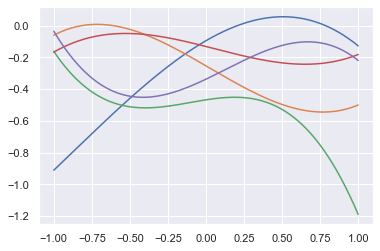

In [4]:
fig = plt.figure(figsize=(6, 4))
ax = fig.subplots(1, 1)
xs = np.linspace(-1, 1, 1000)
for w in w_sample:
    result = list(map(lambda x: np.dot(w, polynomial(x, degree)), xs))
    ax.plot(xs, result, '-')

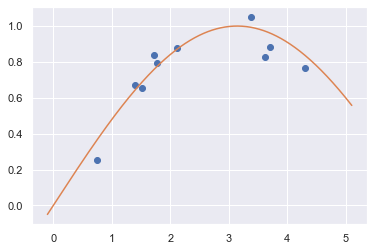

In [5]:
# テスト用の分布を用意
def true_func(x):
    return np.sin(0.5 * x)

def generate_samples(x, var=0.1):
    return stats.norm.rvs(true_func(x), var)

# Random x data with noise
x_min = 0
x_max = 5
var_y = 0.07
sample_x = x_min + (x_max - x_min) * np.random.rand(10)
sample_y = np.vectorize(generate_samples)(sample_x, var=var_y)

# Plot sample_x and sample_y
fig = plt.figure(figsize=(6, 4))
ax = fig.subplots(1, 1)
ax.plot(sample_x, sample_y, 'o')

# Plot true function
xs = np.linspace(x_min-0.1, x_max+0.1, 1000)
true_y = np.vectorize(true_func)(xs)
ax.plot(xs, true_y)

In [6]:
def outer(x, degree=3):
    poly_x = polynomial(x, degree)
    return np.outer(poly_x, poly_x)

sum(list(map(outer, sample_x)))

array([[1.00000000e+01, 2.42799099e+01, 7.22276419e+01, 2.43790102e+02],
       [2.42799099e+01, 7.22276419e+01, 2.43790102e+02, 8.83844173e+02],
       [7.22276419e+01, 2.43790102e+02, 8.83844173e+02, 3.33523668e+03],
       [2.43790102e+02, 8.83844173e+02, 3.33523668e+03, 1.28896074e+04]])

In [38]:
# Calculate parameters for posterior dist
## Covariance matrix 
var_w =  0.1

def outer(x, degree=3):
    poly_x = polynomial(x, degree)
    return np.outer(poly_x, poly_x)

outer_sum = sum(list(map(outer, sample_x)))

assert outer_sum.shape == np.identity((degree+1)).shape

sigma_hat_inv = (1.0 / var_y) *  outer_sum + (1.0 /  var_w) * np.identity((degree+1))
sigma_hat = np.linalg.inv(sigma_hat_inv) 

sum_yf = sum(map(lambda xy:np.array(polynomial(x=xy[0], degree=degree)) * xy[1], zip(sample_x, sample_y)))
tmp_ar = (1.0/var_y) * sum_yf
mu_hat = np.dot(sigma_hat, tmp_ar)

In [39]:
mu_hat.shape

(4,)

In [34]:
# Sampling from posterior
size = 10
post_w_sample = stats.multivariate_normal.rvs(mean=mu_hat, cov=sigma_hat, size=size)

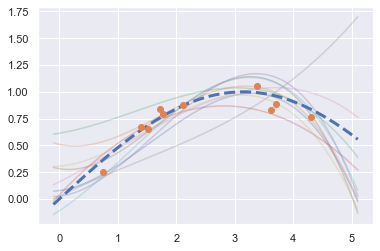

In [40]:
fig = plt.figure(figsize=(6, 4))
ax = fig.subplots(1, 1)
xs = np.linspace(x_min-0.1, x_max+0.1, 1000)
true_y = np.vectorize(true_func)(xs)

for w in post_w_sample:
    sample_prior = list(map(lambda x:np.dot(w, polynomial(x=x, degree=degree)), xs))
    ax.plot(xs, sample_prior, '-', alpha=0.3)
ax.plot(xs, true_y, '--', lw=3)
ax.plot(sample_x, sample_y, 'o')

# Predictive Distribution

In [47]:
def mu_pred(x, mu_tr, degree):
    feature = polynomial(x, degree)
    return np.dot(mu_tr.T, feature)

def var_pred(x, sig_tr, degree):
    feature = polynomial(x, degree)
    fsf = np.dot(feature.T, sig_tr)
    fsf = np.dot(fsf, feature)
    return var_y + fsf

mu_s_s = np.array(list(map(lambda x:mu_pred(x, mu_tr=mu_hat, degree=degree), xs)))
var_s_s = np.array(list(map(lambda x:var_pred(x, sig_tr=sigma_hat, degree=degree), xs)))

In [50]:
post_w_sample.shape

(10, 4)

No handles with labels found to put in legend.


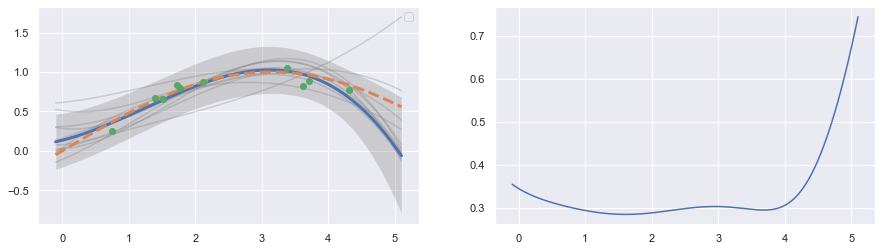

In [57]:
# plot
fig = plt.figure(figsize=(15, 4))
ax = fig.subplots(1,2)

for w in post_w_sample:
    sample_posterior = list(map(lambda x: np.dot(w, polynomial(x=x, degree=degree)), xs))
    ax[0].plot(xs, sample_posterior, '-', color='gray', alpha=0.3)

# mean predicted function
ax[0].plot(xs, mu_s_s, lw=3)

# predicted area
sig_s_s = np.sqrt(var_s_s)
lb = mu_s_s - sig_s_s
ub = mu_s_s + sig_s_s
ax[0].fill_between(xs, lb, ub, facecolor='gray',alpha=0.3)

# True Function
ax[0].plot(xs, true_y, '--', lw=3)

# Sampled Data
ax[0].plot(sample_x, sample_y, 'o')

## 予測の分散（不確実性）のプロッt
ax[1].plot(xs, sig_s_s)

ax[0].legend(loc="best")